<a href="https://colab.research.google.com/github/sunnykart11/AIFFEL_quest_cr/blob/main/Exploration/Quest05/%EC%B1%97%EB%B4%872.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 모델 만들기

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0])
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    if isinstance(inputs, tf.SparseTensor):
        inputs = tf.sparse.to_dense(inputs)
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


In [28]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output


In [29]:
#멀티헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [30]:
# 마스킹
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [31]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [32]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [33]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [34]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [35]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

2. 데이터 전처리

In [80]:
import re

# 하이퍼파라미터
VOCAB_SIZE = 12000
MAX_LEN = 20
BATCH_SIZE = 64
BUFFER_SIZE = 10000
START_TOKEN = '[START]'
END_TOKEN = '[END]'
PAD_TOKEN = '[PAD]'

# CSV 불러오기
df = pd.read_csv("/content/drive/MyDrive/transformer_chatbot/ChatbotData.csv")
questions = df['Q'].astype(str).tolist()
answers = df['A'].astype(str).tolist()

# 문장 전처리 함수 (한글 + 띄어쓰기 기반)
def preprocess(text):
    text = re.sub(r"[^ㄱ-ㅎ가-힣0-9\s.,?!]", "", text)  # 한글, 숫자, 특수기호 허용
    text = text.strip()
    return text

# 질문, 답변 전처리
questions_clean = [preprocess(q) for q in questions]
answers_clean = [preprocess(a) for a in answers]

# 띄어쓰기 기반 토크나이저
questions_tok = [' '.join(q.split()) for q in questions_clean]
answers_tok = [' '.join(a.split()) for a in answers_clean]

# 토크나이저 학습
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token='[UNK]', filters='', lower=False)
tokenizer.fit_on_texts([START_TOKEN, END_TOKEN, PAD_TOKEN] + questions_tok + answers_tok)

start_id = tokenizer.word_index[START_TOKEN]
end_id = tokenizer.word_index[END_TOKEN]
pad_id = tokenizer.word_index[PAD_TOKEN]

# 정수 인코딩 함수
def encode_sentences(sentences, tokenizer, max_len):
    result = []
    for sentence in sentences:
        tokens = tokenizer.texts_to_sequences([sentence])[0]
        tokens = [start_id] + tokens + [end_id]
        tokens = tokens[:max_len]
        tokens += [pad_id] * (max_len - len(tokens))
        result.append(tokens)
    return np.array(result)

# 인코딩
encoder_inputs = encode_sentences(questions_tok, tokenizer, MAX_LEN)
decoder_inputs = encode_sentences(answers_tok, tokenizer, MAX_LEN)

# 디코더 타겟 (한 칸 오른쪽 shift)
decoder_targets = np.concatenate(
    [decoder_inputs[:, 1:], np.zeros((decoder_inputs.shape[0], 1), dtype=np.int64)],
    axis=1
)

# TensorFlow Dataset 생성
dataset = tf.data.Dataset.from_tensor_slices(((encoder_inputs, decoder_inputs), decoder_targets))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


3. 모델학습

In [81]:
# 모델 정의
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [97]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()
model.save("/content/drive/MyDrive/transformer_chatbot/transformer_chatbot.h5")

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',        # 또는 'val_loss'
    patience=3,            # 3 epoch 동안 개선 없으면 종료
    restore_best_weights=True
)

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_inputs          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_padding_mask    │ (None, 1, 1,      │          0 │ inputs[0][0]      │
│ (Lambda)            │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, None, 256) │  4,126,208 │ inputs[0][0],     │
│ (Functional)        │                   │            │ enc_padding_mask… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ look_ahead_mask     │ (None, 1, None,   │          0 │ dec_inputs[0][0]  │
│ (Lambda)            │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_padding_mask    │ (None, 1, 1,      │          0 │ inputs[0][0]      │
│ (Lambda)            │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, None, 256) │  4,653,568 │ dec_inputs[0][0], │
│ (Functional)        │                   │            │ encoder[0][0],    │
│                     │                   │            │ look_ahead_mask[… │
│                     │                   │            │ dec_padding_mask… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Dense)     │ (None, None,      │  3,084,000 │ decoder[0][0]     │
│                     │ 12000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,863,776 (45.26 MB)

 Trainable params: 11,863,776 (45.26 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
# 손실 함수
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(y_true, y_pred):
    # 마스크를 생성하여 PAD 토큰의 손실은 제외
    mask = tf.math.logical_not(tf.math.equal(y_true, pad_id))  # pad_id는 PAD 토큰의 인덱스
    loss_ = loss_object(y_true, y_pred)  # (batch, seq_len)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask  # 패딩 토큰 무시

    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)  # 평균 손실 (패딩 제외)

# 정확도 함수
def accuracy_function(y_true, y_pred):
    predictions = tf.argmax(y_pred, axis=2, output_type=tf.int64)  # 예측된 단어 인덱스
    matches = tf.equal(y_true, predictions)

    mask = tf.math.logical_not(tf.math.equal(y_true, pad_id))
    matches = tf.math.logical_and(mask, matches)

    matches = tf.cast(matches, tf.float32)
    mask = tf.cast(mask, tf.float32)

    return tf.reduce_sum(matches) / tf.reduce_sum(mask)


In [99]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [100]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy_function])

In [101]:
EPOCHS = 30
history2=model.fit(dataset, epochs=EPOCHS, callbacks=[early_stopping])

Epoch 1/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - accuracy_function: 0.1481 - loss: 8.9674
Epoch 2/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy_function: 0.3532 - loss: 6.9803
Epoch 3/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy_function: 0.3711 - loss: 5.2972
Epoch 4/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy_function: 0.3932 - loss: 4.7810
Epoch 5/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy_function: 0.4156 - loss: 4.4565
Epoch 6/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy_function: 0.4374 - loss: 4.1039
Epoch 7/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy_function: 0.4631 - loss: 3.7711
Epoch 8/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy_function: 0.5018 - loss: 3.4077
Epoch 9/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy_function: 0.5511 - loss: 3.0117
Epoch 10/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy_function: 0.6016 - loss: 2.5935
Epoch 11/30
185/185 ━━━━━━━━━━━━━━━━

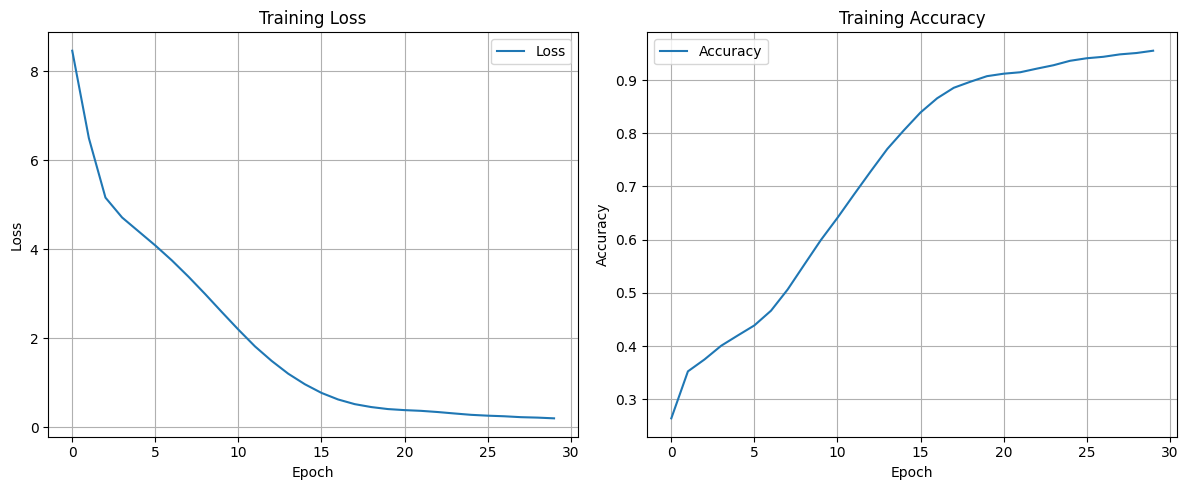

In [104]:
# 손실 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 정확도 시각화 (사용자 정의 metric 함수 이름을 반영)
acc_key = [key for key in history.history.keys() if 'acc' in key or 'accuracy' in key][0]

plt.subplot(1, 2, 2)
plt.plot(history2.history[acc_key], label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [105]:
def preprocess_sentence(sentence):
    # 한국어 간단 정제
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣0-9\s.,?!]", "", sentence)
    sentence = sentence.strip()
    return ' '.join(sentence.split())

start_token_id = tokenizer.word_index['[START]']
end_token_id = tokenizer.word_index['[END]']
pad_token_id = tokenizer.word_index['[PAD]']

def generate_reply(sentence, tokenizer, model, max_len=40):
    # 입력 전처리 및 정수 인코딩
    sentence = preprocess_sentence(sentence)
    sentence = ' '.join(sentence.split())
    encoder_input = tokenizer.texts_to_sequences([sentence])[0]
    encoder_input = [start_token_id] + encoder_input + [end_token_id]
    encoder_input = encoder_input[:max_len]
    encoder_input += [pad_token_id] * (max_len - len(encoder_input))
    encoder_input = tf.expand_dims(encoder_input, axis=0)

    # 디코더 입력 초기화: [START]
    decoder_input = [start_token_id]
    output = tf.expand_dims(decoder_input, axis=0)

    for i in range(max_len):
        # 예측 수행
        predictions = model(inputs=[encoder_input, output], training=False)
        predictions = predictions[:, -1:, :]  # 마지막 시점의 출력만 사용
        predicted_id = tf.argmax(predictions, axis=-1).numpy()[0][0]

        # [END] 토큰이면 종료
        if predicted_id == end_token_id:
            break

        # 다음 토큰을 디코더 입력에 추가
        output = tf.concat([output, [[predicted_id]]], axis=-1)

    # 정수 → 단어 디코딩
    result = tokenizer.sequences_to_texts(output.numpy())[0]
    result = result.replace(START_TOKEN, '').replace(END_TOKEN, '').strip()

    return result


In [106]:
input_sentence = "배고파"
response = generate_reply(input_sentence, tokenizer, model)
print(f"🙋‍♀️ 사용자: {input_sentence}")
print(f"🤖 챗봇: {response}")

🙋‍♀️ 사용자: 배고파
🤖 챗봇: 뭐 좀 챙겨드세요.


In [107]:
def run_chat(tokenizer, model):
    print("🤖 챗봇을 시작합니다! '종료'를 입력하면 종료됩니다.")
    while True:
        user_input = input("🙋‍♀️ 사용자: ")
        if user_input.lower() in ['종료', 'quit', 'exit']:
            print("🤖 챗봇을 종료합니다.")
            break
        reply = generate_reply(user_input, tokenizer, model)
        print(f"🤖 챗봇: {reply}")

run_chat(tokenizer, model)

🤖 챗봇을 시작합니다! '종료'를 입력하면 종료됩니다.
🙋‍♀️ 사용자: 나 남자친구랑 헤어졌어
🤖 챗봇: 즐거운 시간이 될 거예요.
🙋‍♀️ 사용자: 날씨가 좋네
🤖 챗봇: 좋은 사람이 [UNK]
🙋‍♀️ 사용자: 요즘 기분이 안좋아
🤖 챗봇: 무슨 일이 있었나봐요.
🙋‍♀️ 사용자: 배고프다
🤖 챗봇: [UNK]
🙋‍♀️ 사용자: 배고파
🤖 챗봇: 뭐 좀 챙겨드세요.
🙋‍♀️ 사용자: 치킨 먹을까?
🤖 챗봇: 좀 더 편하게 생각해보세요.
🙋‍♀️ 사용자: 나랑 사귈래?
🤖 챗봇: 저라도 괜찮다면 좋아요.
🙋‍♀️ 사용자: 졸려
🤖 챗봇: 오늘 일찍 주무세요.
🙋‍♀️ 사용자: 지금 몇 시야?
🤖 챗봇: 당신만이 [UNK] 수 있어요.
🙋‍♀️ 사용자: 나 넘어졌어
🤖 챗봇: [UNK] 바랄게요.
🙋‍♀️ 사용자: 친구랑 싸웠어
🤖 챗봇: 싸우면서 정 들 거예요.
🙋‍♀️ 사용자: 이사 갈 거야
🤖 챗봇: 너무 걱정하지마세요.
🙋‍♀️ 사용자: 이사갈거야
🤖 챗봇: [UNK]
🙋‍♀️ 사용자: 이사 갈래
🤖 챗봇: 너무 걱정하지마세요.
🙋‍♀️ 사용자: 귀신이야
🤖 챗봇: [UNK]
🙋‍♀️ 사용자: 주식이 올랐어
🤖 챗봇: 잘 지내길 바랍니다.
🙋‍♀️ 사용자: 종료
🤖 챗봇을 종료합니다.
